<a href="https://colab.research.google.com/github/danielsaggau/Elections-Belarus/blob/main/Belarus_ML_Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleansing 

In the first part of this analysis, we need to undertake some pre-processing steps. 


In [3]:
import pandas as pd
import numpy as np
df_pls=pd.read_excel("df_merge_n.xlsx")

In [ ]:
df_pls_pls=df_pls.drop(columns=['Unnamed: 0'])
df_pls_pls=df_pls_pls.fillna(0)
df_pls_new=df_pls_pls.drop(columns=['commission_code','number_of_cite'])
df_pls_new.info()

In [5]:
df_merge1=df_pls_new.drop(columns=['attachment1','attachment2','attachment3','attachment4','attachment5','comment','id','type','name','location','origin','area'])
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 35 columns):
 #   Column                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                    --------------  -----  
 0   region                                                                                                                    1583 non-null   object 
 1   city_or_district_within_the_region                                                                                        1583 non-null   object 
 2   area_in_the_city                                                                                                          1583 non-null   object 
 3   settlement                                                                                                                1583 non-nu

# Feature Engineering 
We can now calculate the share of votes for Lukashenko. 

In [9]:
df_merge1['lukashenko_share']=df_merge1['Lukashenko']/df_merge1['number_of_voters_who_took_part_in_the_voting']
df_merge1['lukashenko_share']=df_merge1['lukashenko_share'].replace([np.inf, -np.inf], 0)
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 36 columns):
 #   Column                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                    --------------  -----  
 0   region                                                                                                                    1583 non-null   object 
 1   city_or_district_within_the_region                                                                                        1583 non-null   object 
 2   area_in_the_city                                                                                                          1583 non-null   object 
 3   settlement                                                                                                                1583 non-nu

Now, we can drop some of the obsolete columns. 

In [10]:
df_merge2=df_merge1.drop(columns=['parent_id','description_x','commission_id','work_title','description_y','city_or_district_within_the_region','area_in_the_city','settlement'])

In [11]:
df_merge2.columns

Index(['region',
       'total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election',
       'number_of_voters_who_received_ballots',
       'number_of_voters_who_took_part_in_the_voting',
       'number_of_voters_who_took_part_in_the_early_voting',
       'number_of_voters_who_took_part_in_voting_at_the_place_of_residence',
       'number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station',
       'Dmitriev', 'Kanopatskaya', 'Lukashenko', 'Tikhanovskaya', 'Cherechen',
       'number_of_votes_for_candidates_who_dropped_out_during_early_voting_period',
       'number_of_votes_againts_all_candidates',
       'number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate',
       'number_of_ballots_declared_invalid',
       'number_of_ballots_received_by_election_commission',
       'number_of_spoiled_ballots', 'number_of_unused_ballots', 'latitude',
       'longitude', 'doctor', 'army', 'edu

In [12]:
df_merge2['region'].unique()

array(['Брестская', 0, 'Витебская', 'Гомельская', 'Гродненская',
       'Минская', 'Могилевская', 'город Минск'], dtype=object)

Next we need to rename the regions and change no region to 0: 

In [13]:
df_merge2['region']=df_merge2['region'].replace('Брестская','brestskaya')
df_merge2['region']=df_merge2['region'].replace('Витебская','vitebskaya')
df_merge2['region']=df_merge2['region'].replace('Гомельская','gomelskaya')
df_merge2['region']=df_merge2['region'].replace('Гродненская','grodnenskaya')
df_merge2['region']=df_merge2['region'].replace('Минская','miskaya')
df_merge2['region']=df_merge2['region'].replace('Могилевская','mogilevskaya')
df_merge2['region']=df_merge2['region'].replace('город Минск','minsk')
df_merge2.region=df_merge2.region.replace(0, 'no_region')

Based on this variable, we can craete dummy variables for each region. 

In [14]:
df_merge3=pd.get_dummies(df_merge2, 'region')

We can save this dataset as an intermediate dataset.
We also save a version without the region dummies for the regression analysis thereafter, due to the limited number of observations for some regions that could become problematic later on.

In [15]:
df_merge3.info()
df_merge3=df_merge3.fillna(0)
df_merge_d=df_merge3.fillna(0)
df_merge_d.to_excel("df_merge_d.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 35 columns):
 #   Column                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                    --------------  -----  
 0   total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election  1583 non-null   int64  
 1   number_of_voters_who_received_ballots                                                                                     1583 non-null   int64  
 2   number_of_voters_who_took_part_in_the_voting                                                                              1583 non-null   int64  
 3   number_of_voters_who_took_part_in_the_early_voting                                                                        1583 non-nu

# Random Forest for Feature Selection 

In this section we use a random forest for feature selection.
This section is structured as follows:

1. Specifying our model structure and removing variables that are not needed or variables that should be included for the prediction  
2. Splitting the data set into training and test set 
3. Running the algorithm, using cross validation
4. Plot the feature importance per feature 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Splitting the Dataset and specifying our dependent Variable



In [17]:

# обязательный код
X=df_merge3.drop(columns=['lukashenko_share','Dmitriev','Kanopatskaya','Lukashenko','Tikhanovskaya','Cherechen']).values
y=df_merge3.lukashenko_share.values
# сплитуйте X и y как хотите
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, 
                                                    shuffle=True)

Next we can instantiate our RF regressor.

In [18]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [19]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1600, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}


In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_params_
y_pred=rf_random.predict(X_test)
print('Правильность на обучающем наборе: {:.5f}'.format(rf_random.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.5f}'.format(rf_random.score(X_test, y_test)))

In [ ]:
importance_values=rf_random.best_estimator_.feature_importances_

In [ ]:
importances = rf_random.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [ ]:
feature_importance_labels=df_merge3.drop(columns=['lukashenko_share','Dmitriev', 'Kanopatskaya', 'Lukashenko', 'Tikhanovskaya', 'Cherechen'])

In [ ]:
column_names=list(feature_importance_labels.columns)

In [ ]:
column_names

In [ ]:
values_imp=list(importance_values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
 
courses = ['total','receiv','tookpart','earlvoting','residence','electday','dur_earl_vot','againts_all','held_on','invalid','rec_comm','spoiled','unusedb','latitude','longitude','doctor','army','education','science','prof_union','economics','brest','gomel', 'grod','minsk','miskaya','mogilev','no_region','vitebsk']
values = values_imp

plt.bar(courses, values, color ='blue')

plt.xticks(rotation = 60)
plt.show()

In [ ]:
df_merge3.isna().sum()


# Feature Selection, Regression Analysis and Exploratory Data Analysis in R
We undertake the regression models in R. 
The following sections are structured as follows: 

1.   Lasso Regression compared to a naive model 
2.   Regression model with the selected features for LASSO
3.   Regression model with the selected features for the random forest 
4.   Feature importance in lasso regression compared to the random forest.  
5.   Exploration of unsupervised learning methods Part 1: Principal Component Analysis 
6.   Exploration of unsupervised learning methods Part 2: Latent Dirichlet Allocation 
7.   Geospatial Analysis of Voting Behaviour 

Prior to including R code, we need to install 'rpy2' package.
Further, every cell needs to start with %%R for the Markdown file to differentiate between R code and Python code.

In [23]:
!pip install rpy2
%load_ext rpy2.ipython

## LASSO Regression for Feature Selection

In the first step we need to install our packages and set our seed for replicability.

In [ ]:
%%R

install.packages("skimr")
install.packages("glmnet")
install.packages("plotmo")

library(readxl)
library(MASS)
library(tidyverse)
library(broom)
library(skimr)
library(glmnet)
library(plotmo)
set.seed(144)

## Splitting the data 

In the first step, we split the data into training and test set. 
We use a split of 0.66.
For reference, we are using a slightly modified dataset here because we use regression as a categorical variable and not use dummies for each region due to the limited number of observations which prove to be inconvient for subsequent regression analysis. Irrespective, we will later on look at geospatial voting information to get a more fine grained picture of what the geospatial variation looks like. 

In [193]:
%%R
data = read_excel("df_merge_d.xlsx")
data = select(data, -c("region_no_region", "number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate","...1" )) # removed due to too few observations
data = select(data, -c("region_brestskaya","region_gomelskaya","region_grodnenskaya", "region_minsk","region_miskaya","region_mogilevskaya","region_vitebskaya")) # removed due to too few observations ill suited for cross validation 
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen"))
 colnames(data)[1:12] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")
 skim(data)

R[write to console]: New names:
* `` -> ...1



── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1583  
Number of columns          21    
_______________________          
Column type frequency:           
  numeric                  21    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable    n_missing complete_rate      mean       sd    p0      p25
 1 total                    0             1 1719.      684.      0   1318    
 2 received                 0             1 1391.      583.      0   1048    
 3 took_part                0             1 1391.      580.      0   1050.   
 4 part_early               0             1  565.      309.      0    342.   
 5 part_residence           0             1   46.0      63.7     0     11    
 6 part_electionday         0             1  779.      399.      0    516.   
 7 dropped               

In [194]:
%%R

p = ncol(data) -1
n <- nrow(data)

ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 
skim(set_train)

── Data Summary ────────────────────────
                           Values   
Name                       set_train
Number of rows             1045     
Number of columns          21       
_______________________             
Column type frequency:              
  numeric                  21       
________________________            
Group variables            None     

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable    n_missing complete_rate      mean       sd    p0      p25
 1 total                    0             1 1762.      673.      0   1391    
 2 received                 0             1 1416.      576.      0   1076    
 3 took_part                0             1 1419.      573.      0   1076    
 4 part_early               0             1  574.      303.      0    351    
 5 part_residence           0             1   46.6      67.6     0     11    
 6 part_electionday         0             1  796.      399.      0    528   

Now we can also look at some summary statistics.
Optionally, we can also look at summary statistics itself using the summary command, but some recent data exploration packages allow for a more interesting look at different variables also plotting 

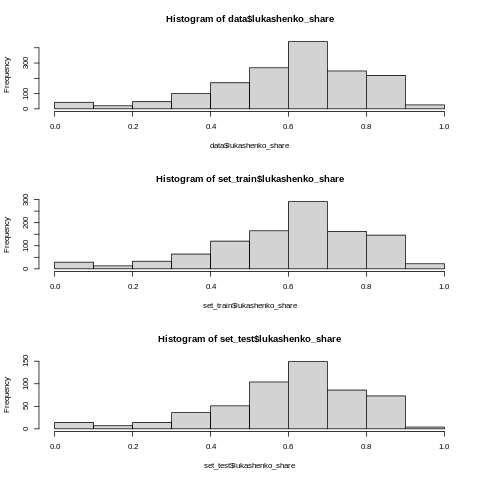

In [119]:
%%R
par(mfrow = c(3, 1))
hist(data$lukashenko_share) 
hist(set_train$lukashenko_share)
hist(set_test$lukashenko_share)

## Correlation Plot

Next we can also look at the correlation plot

In [ ]:
%%R
install.packages("corrplot")
library(corrplot)

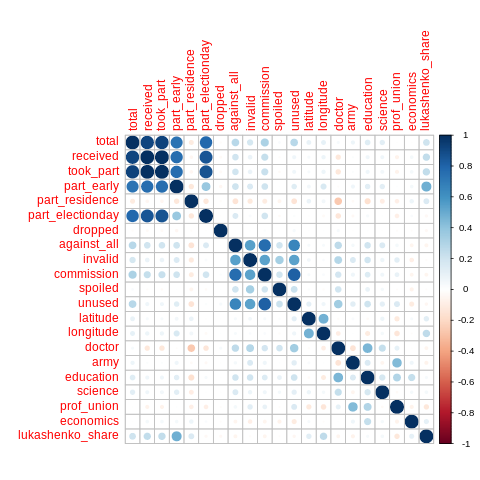

In [120]:
%%R
correl = cor(data)
corrplot(correl)

# Naive Regression Model

In [121]:
%%R
model_naive = lm(lukashenko_share~., data = set_train)
summary(model_naive)


Call:
lm(formula = lukashenko_share ~ ., data = set_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56820 -0.08916  0.00956  0.09149  0.63597 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.156e-01  1.969e-01  -0.587  0.55732    
total            -5.096e-05  2.355e-05  -2.164  0.03073 *  
received          1.810e-06  5.153e-05   0.035  0.97198    
took_part         9.054e-05  9.734e-05   0.930  0.35251    
part_early        3.313e-04  8.144e-05   4.069 5.09e-05 ***
part_residence    4.649e-04  1.083e-04   4.292 1.94e-05 ***
part_electionday -1.485e-04  7.993e-05  -1.858  0.06342 .  
dropped          -4.000e-04  8.847e-04  -0.452  0.65127    
against_all      -2.664e-04  1.122e-04  -2.375  0.01774 *  
invalid          -1.688e-04  2.294e-04  -0.736  0.46201    
commission       -1.732e-05  1.022e-05  -1.694  0.09050 .  
spoiled           5.114e-04  7.591e-04   0.674  0.50066    
unused            5.783e-05  3.497e-05   

# Lasso Model 


In [122]:
%%R
model_lasso = glmnet(x = as.matrix(set_train[,-(p+1)]), y = set_train$lukashenko_share, alpha =1)

## Cross Validation 


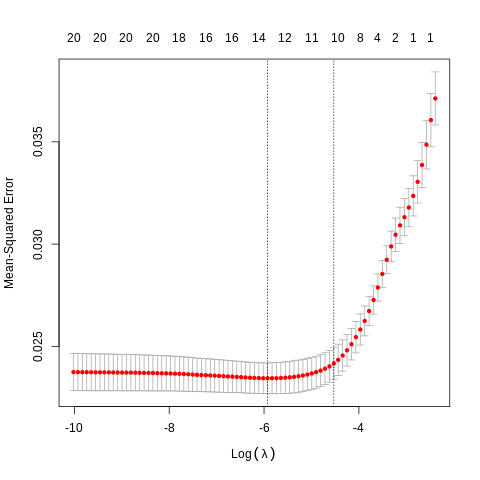

In [123]:
%%R
cv<-cv.glmnet(as.matrix(set_train[-(p+1)]), set_train$lukashenko_share,nfolds = 3) 
plot(cv)

## Selecting the optimal Lambda parameter

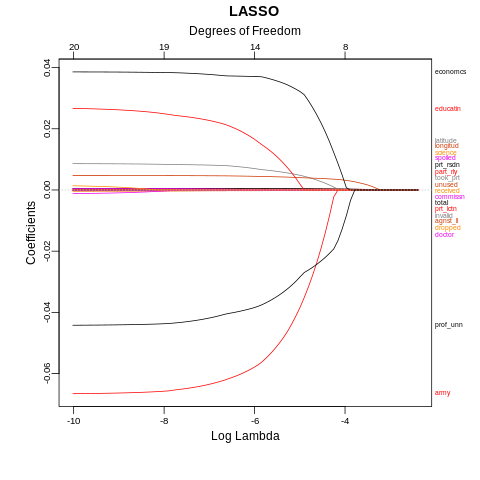

In [124]:
%%R
lambda_lasso = cv.glmnet(x = as.matrix(set_train[,-(p+1)]),y = set_train$lukashenko_share, alpha =1)$lambda.min

# Plot log lambda
plot_glmnet(x = model_lasso, label = TRUE, xvar = "lambda")
title(main = "LASSO", line = 3)


We can first look at how our models perform on our training data.
Here we are comparing a random forest and a lasso model. 

In [125]:
%%R
y_train = set_train$lukashenko_share
predict_train = matrix(data =0, nrow= nrow(set_train), ncol=2)

predict_train[, 1] = predict(object = model_naive, newdata = set_train[, -(p + 1)])
predict_train[,2] = predict.glmnet(object = model_lasso, 
                                  newx = as.matrix(set_train[,-(p + 1)]),
                                  s = lambda_lasso)

colnames(predict_train) =c("Naive Model", "Lasso Model")

In [126]:
%%R
MSE_train = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_train[i] = mean((y_train-predict_train[,i])^2)
}
names(MSE_train) = c("Naive Model", "Lasso Model")
MSE_train

Naive Model Lasso Model 
 0.02252742  0.02373286 


Predicting on our training data, we can see that the OLS model without regularization performs better than the Lasso model, although they are somewhat similar. 
Subsequently, we can look at how our model performs when dealing with new data. 
Therefore, we use the test set and again predict our naive and our lasso model.

In [127]:
%%R
y_test = set_test$lukashenko_share
predict_test = matrix(data =0, nrow= nrow(set_test), ncol=2)

predict_test[, 1] = predict(object = model_naive, newdata = set_test[, -(p + 1)])
predict_test[,2] = predict.glmnet(object = model_lasso,  newx = as.matrix(set_test[,-(p+1)]),
                                  s = lambda_lasso)

colnames(predict_test) =c("Naive Model", "Lasso Model")

MSE_test = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_test[i] = mean((y_test-predict_test[,i])^2)
}
names(MSE_test) = c("Naive Model", "Lasso Model")
MSE_test

Naive Model Lasso Model 
 0.02205670  0.02204281 


# Feature Importance for Lasso Regression 
 
 For comparability, we also include 

In [128]:
%%R
set.seed(123)
install.packages("ranger")
install.packages("vip")
library(ranger)
library(vip) # Link: https://koalaverse.github.io/vip/articles/vip.html

R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmpZx2Kp6/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘gridExtra’, ‘plyr’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gridExtra_2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1062844 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

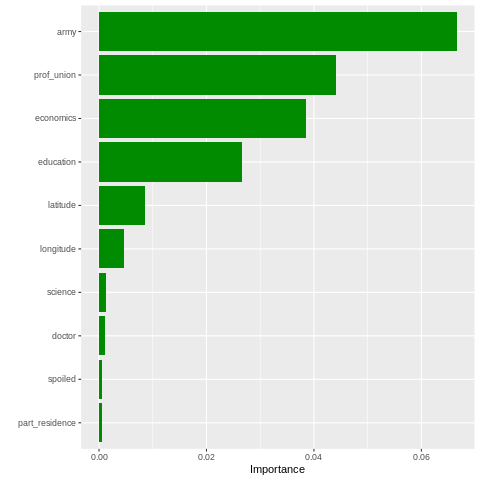

In [129]:
%%R
# backward <- step(model_lasso, direction = "backward", trace = 0)
vip(model_lasso, width = 0.5, aesthetics = list(fill = "green4"))

# OLS Regression with selected features

Here we can see a very different performance. 
The Lasso model performs substantially better then the OLS model.
Therefore, using this method has led to better predictive performance. 
Lastly, we can also use the lasso specification for a OLS model, trained on test data to ensure that we have no incorrect standard errors.
This is a pivotal concern within in economics, because we need correct standard errors to interpret our coefficients and ensure causality. 

As a first step we can look at the coefficients in the lasso model:

In [ ]:
%%R
coef_lasso <- model_lasso$beta[, which(model_lasso$lambda == lambda_lasso)]
which(coef_lasso!=0)

                                 number_of_voters_who_took_part_in_the_early_voting 
                                                                                  4 
                 number_of_voters_who_took_part_in_voting_at_the_place_of_residence 
                                                                                  5 
number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station 
                                                                                  6 
                                             number_of_votes_againts_all_candidates 
                                                                                  7 
                                  number_of_ballots_received_by_election_commission 
                                                                                  9 
                                                          number_of_spoiled_ballots 
                                                                 

The advantage of the lasso method is that we induce sparsity.
Here we can see that various features turn to 0.
One could also argue that due to correlation between some features, explanatory or variance was ascribed to either the one or the other variable. 
We can see that the variables that were more correlated (see correlation plot above) frequently scored 0 here. 
Now we can specify a model with the relevant coefficients, and run the model on the test data. 

In [ ]:
%%R
model = lm(lukashenko_share ~  number_of_voters_who_took_part_in_the_early_voting  + number_of_voters_who_took_part_in_voting_at_the_place_of_residence + number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station  + number_of_votes_againts_all_candidates + number_of_ballots_received_by_election_commission + number_of_spoiled_ballots +  longitude + army + education + prof_union + economics , data = set_test)
summary(model)


Call:
lm(formula = lukashenko_share ~ number_of_voters_who_took_part_in_the_early_voting + 
    number_of_voters_who_took_part_in_voting_at_the_place_of_residence + 
    number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station + 
    number_of_votes_againts_all_candidates + number_of_ballots_received_by_election_commission + 
    number_of_spoiled_ballots + longitude + army + education + 
    prof_union + economics, data = set_test)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52227 -0.08249  0.00832  0.09160  0.53253 

Coefficients:
                                                                                      Estimate
(Intercept)                                                                          4.188e-02
number_of_voters_who_took_part_in_the_early_voting                                   3.388e-04
number_of_voters_who_took_part_in_voting_at_the_place_of_residence                   3.808e-04
number_of_voters_who_took_part_in_th

# Alternative Methods: Unsupervised Learning via Principal Component Analysis 

In addition to supervised learning, we can also look at feature importance from the perspective of unsupervised learning.
One popular dimensionality reduction technique is principal component analysis or in short PCA. 


In [ ]:
%%R
# install.packages("ggfortify")
library(ggfortify)
library(devtools)


R[write to console]: Loading required package: usethis



In [ ]:
%%R
data_n = data[-2]
PCA = prcomp(data_n, scale. = TRUE,center = TRUE)
summary(PCA)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.0175 1.6987 1.32442 1.23797 1.20392 1.04235 1.01096
Proportion of Variance 0.2142 0.1519 0.09232 0.08066 0.07629 0.05718 0.05379
Cumulative Proportion  0.2142 0.3661 0.45843 0.53909 0.61538 0.67256 0.72635
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.95979 0.91104 0.86756 0.71703 0.69815 0.66783 0.64619
Proportion of Variance 0.04848 0.04368 0.03961 0.02706 0.02565 0.02347 0.02198
Cumulative Proportion  0.77484 0.81852 0.85813 0.88519 0.91085 0.93432 0.95630
                          PC15    PC16    PC17    PC18    PC19
Standard deviation     0.57593 0.54150 0.38133 0.22894 0.08734
Proportion of Variance 0.01746 0.01543 0.00765 0.00276 0.00040
Cumulative Proportion  0.97375 0.98919 0.99684 0.99960 1.00000


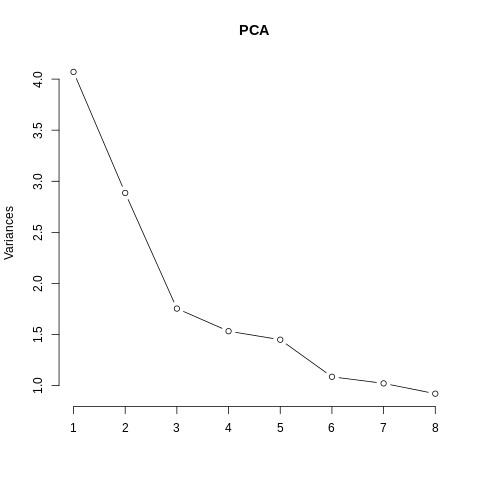

In [ ]:
%%R
screeplot(PCA, npcs =8, type = "lines")


Optional: Further Analysis 

Future analysis could also use further graphical tools to examine variation in subgroups. 

R[write to console]: Loading required package: plyr

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: 
Attaching package: ‘plyr’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following object is masked from ‘package:purrr’:

    compact


R[write to console]: Loading required package: scales

R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:plotrix’:

    rescale


R[write to console]: The following object i

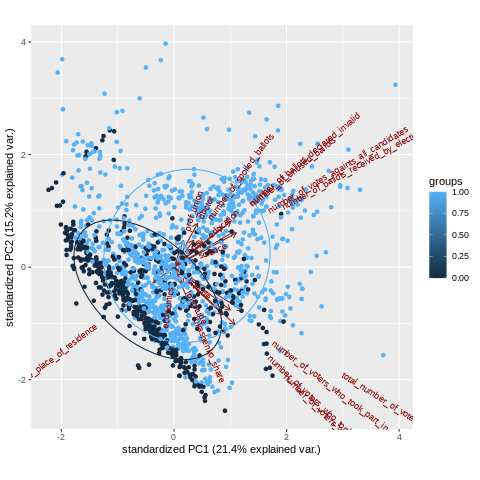

In [ ]:
%%R
# install_github("vqv/ggbiplot")
 library(ggbiplot)
ggbiplot(PCA,ellipse=TRUE, groups= data$education)
#autoplot(PCA, colour = "lukashenko_share", loadings =T,loading.label =T,loadings.label.size = 20)

# Alternative Methods: Unsupervised Learning via Latent Dirichlet Allocation 



In [ ]:
%%R
install.packages("topicmodels")
#install.packages("tidytext")
#install.packages("lda")
#install.packages("tm")

library(tidyverse)
library(tidytext)
library(topicmodels)
library(lda)
library(tm)

In [ ]:
%%R
install.packages("githubinstall")
library(githubinstall)
githubinstall("topicmodels")
#library(tm)
library(topicmodels)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
install.packages("lda")
library(lda)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
data = read_excel("/df_merge_n.xlsx")
data = unite(data, col = "text", commission_code:economics, sep =" ")
summary(data)

## Cleaning the Text data 


In [ ]:
%%R
data = data %>%
  select("text")

cleaner <- function(text){
  text <- tolower(text)
  text <- gsub("rt", "", text)
  text <- gsub("@\\w+", "", text)
  text <- gsub("[[:punct:]]", "", text)
  text <- gsub("http\\w+", "", text)
  text <- gsub("amp", " ", text)
  text <- gsub("[ |\t]{2,}", "", text)
  text <- gsub("^ ", "", text)
  text <- gsub(" $", "", text)
  text <- gsub(" +", " ", text)
  text <- gsub("=", " ", text)
  text <- gsub('<.*>', '', enc2native(text))
  text <- unique(text)
  return(text)
}

In [ ]:
%%R
polish <- function(text){
  text <- VCorpus(VectorSource(text))
  text <- tm_map(text, removeWords, stopwords("russian")) # used to be english, still WIP
  text <- tm_map(text, removeNumbers)
  text <- tm_map(text, stemDocument)
}

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
text = data$text 
text <- cleaner(text)
corpus <- polish(text)

In [ ]:
%%R
doc.lengths <- rowSums(as.matrix(DocumentTermMatrix(corpus)))
dtm <- DocumentTermMatrix(corpus[doc.lengths > 0])


## Setting up our Topic Model using VEM


In [ ]:
%%R

LDA_V <- LDA(dtm, k =3,method = "VEM", cotrol = list(seed=1234))
topics_1 <- tidy(LDA_V, matrix ="beta")

Next we can order the terms and select only the top 10 terms. 

In [ ]:
%%R
ap_top_terms <- topics_1 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

Now we can plot these terms using ggplot: 

In [ ]:
%%R
ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

## Topic Model with Gibbs sampling 

We can also modify our topic model by using gibbs sampling

In [ ]:
%%R
LDA_G <- LDA(x=dtm, k=2, method="Gibbs",control=list(alpha=1, delta=0.1, seed=10005))
topics_2 <- tidy(LDA_V, matrix ="beta")

ap_top_terms <- topics_2 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

  ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

# Geospatial Analysis (#TODO)

We cal also plot the votes by area. 


In [ ]:
%%R
library(ggplot2)
library(sf)
library(maps)

geo = st_read("~/Downloads/BelarusElections 4/gis files for BLR and poland/BLR_Adm/BLR_adm2.shp")
dist = st_read("~/Downloads/BelarusElections 4/gis files for BLR and poland/BLR_Adm/BLR_adm1.shp")
road = st_read("~/Downloads/BelarusElections 4/gis files for BLR and poland/BLR_rds/BLR_roads.shp")
data <- read_excel("df_merge_d.xlsx", sheet = "Sheet1")

merge(geo, data, by.x= region, by.y=region)

plot = ggplot()+ geom_sf(data = geo, mapping = aes(geometry = geometry)) + 
  geom_sf(data= dist, aes(geometry = geometry)) + 
  geom_sf(data= road, aes(geometry = geometry)) 

map = plot + geom_point(data = bela, mapping = aes(fill = "region")) + coord_sf()
map


## Appendix 
### Optional: Network Analysis 



In [ ]:
%%R
install.packages("ggraph")
install.packages("igraph")
library(ggraph)
library(igraph)

trigrams_separated <- trigram %>%
  separate(trigram, c("word1", "word2"), sep = " ")

trigrams_filtered <- trigrams_separated %>%
  filter(!word1 %in% c("")) %>%
  filter(!word2 %in% stop_words$word)

# new bigram counts:
trigram_counts <- trigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
trigram_counts
trigram_graph <- trigram_counts %>%
  filter(n > 800) %>%
  graph_from_data_frame()

ggraph(trigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)


trigrams_filtered %>%
    filter(!(word1 == "na")) %>%
  filter(!(word2 == "na")) %>%
  count(word1, sort = TRUE)

In [ ]:
%%R
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(trigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

### Feature Importance Random Forest Implementation in R

In [ ]:
%%R

rfo <- ranger(lukashenko_share ~ ., data = data, importance = "permutation")
rfo
vi_rfo <- rfo$variable.importance
vi_rfo
barplot(vi_rfo, horiz = TRUE, las = 1)
vip(rfo, width = 0.5, aesthetics = list(fill = "green3"))


In [195]:
%%R
data <- read_excel("df_merge_d.xlsx")

R[write to console]: New names:
* `` -> ...1



## Exclusion Regions 


In [198]:
%%R
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen")) # removing other candidate votes
data = select(data, -c("region_no_region", "number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate","...1" ))
# data = select(data, -c("region_brestskaya","region_gomelskaya","region_grodnenskaya", "region_miskaya","region_mogilevskaya","region_vitebskaya"))
colnames(data)[1:12] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")

R[write to console]: Error: Can't subset columns that don't exist.
✖ Column `Dmitriev` doesn't exist.
Backtrace:
  1. (function (expr, envir = parent.frame(), enclos = if (is.list(envir) || ...
  5. dplyr:::select.data.frame(...)
  6. tidyselect::eval_select(expr(c(...)), .data)
  7. tidyselect:::eval_select_impl(...)
 15. tidyselect:::vars_select_eval(...)
     ...
 24. tidyselect:::as_indices_impl(x, vars, strict = strict)
 25. tidyselect:::chr_as_locations(x, vars)
 26. vctrs::vec_as_location(x, n = length(vars), names = vars)
 28. vctrs:::stop_subscript_oob(...)
 29. vctrs:::stop_subscript(...)




Error: Can't subset columns that don't exist.
✖ Column `Dmitriev` doesn't exist.
Backtrace:
  1. (function (expr, envir = parent.frame(), enclos = if (is.list(envir) || ...
  5. dplyr:::select.data.frame(...)
  6. tidyselect::eval_select(expr(c(...)), .data)
  7. tidyselect:::eval_select_impl(...)
 15. tidyselect:::vars_select_eval(...)
     ...
 24. tidyselect:::as_indices_impl(x, vars, strict = strict)
 25. tidyselect:::chr_as_locations(x, vars)
 26. vctrs::vec_as_location(x, n = length(vars), names = vars)
 28. vctrs:::stop_subscript_oob(...)
 29. vctrs:::stop_subscript(...)


In [199]:
%%R
data = data %>%
na.omit(lukashenko_share ==0)
data$lukashenko_share


p = ncol(data) -1
n <- nrow(data)



In [220]:
%%R
ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 
#skim(set_train)

#skim(data)
# summary(data)

#par(mfrow = c(3, 1))
#summary(data$region_vitebskaya)
#summary(set_test$region_vitebskaya)
#summary(set_train$region_vitebskaya)

model_naive_all_b_minsk = lm(lukashenko_share~.- region_minsk, data = set_train)
model_naive_none = lm(lukashenko_share~.- region_minsk -region_brestskaya - region_grodnenskaya - region_gomelskaya-region_minsk-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_none_b_minsk = lm(lukashenko_share~. -region_brestskaya - region_grodnenskaya - region_gomelskaya-region_minsk-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_all = lm(lukashenko_share~., data = set_train)

## Analysis of Variance for the dummy variables

In the Lasso Regression model comparison we excluded the dummies because the results were instabil due to the limited number of observations in the dummy variables. 

In [219]:
%%R
#export_summs(model_naive, model_naive_m)
anova(model_naive_none, model_naive_none_b_minsk, model_naive_all_b_minsk, model_naive_all)

Analysis of Variance Table

Model 1: lukashenko_share ~ (total + received + took_part + part_early + 
    part_residence + part_electionday + dropped + against_all + 
    invalid + commission + spoiled + unused + latitude + longitude + 
    doctor + army + education + science + prof_union + economics + 
    region_brestskaya + region_gomelskaya + region_grodnenskaya + 
    region_minsk + region_miskaya + region_mogilevskaya + region_vitebskaya) - 
    region_minsk - region_brestskaya - region_grodnenskaya - 
    region_gomelskaya - region_minsk - region_miskaya - region_mogilevskaya - 
    region_vitebskaya
Model 2: lukashenko_share ~ (total + received + took_part + part_early + 
    part_residence + part_electionday + dropped + against_all + 
    invalid + commission + spoiled + unused + latitude + longitude + 
    doctor + army + education + science + prof_union + economics + 
    region_brestskaya + region_gomelskaya + region_grodnenskaya + 
    region_minsk + region_miskaya + regio

As one can see, most of the variation is caused by the Minsk dummy variable.
Henceforth, further analysis would potentially profit from including this variable. Due to time constraints this was not implemented here, but could be a consideration for future research. 